In [68]:
import pandas as pd
from glob import glob

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from termcolor import colored

import string
from wordcloud import WordCloud
from nltk.corpus import stopwords

# functions

In [56]:
def all_wordcloud(df):
    vectorizer = TfidfVectorizer(stop_words='english', smooth_idf=True, use_idf=True)
    corpora = df.to_list() 

    vectorizer.fit_transform(corpora)

    # Storing vocab
    feature_names = vectorizer.get_feature_names_out()

    result = []
    for doc in corpora:
        d = {}
        d['full_text'] = doc
        d['top_keywords'] = get_keywords(vectorizer, feature_names, doc)
        result.append(d)

    final = pd.DataFrame(result)

    from collections import defaultdict
    word_frequency = defaultdict(int)

    for i_row in range(final.shape[0]):
        words = final.iloc[i_row].top_keywords
        for word in words:
            word_frequency[word] += 1     
    word_frequency = dict(sorted(word_frequency.items(), key=lambda item: item[1], reverse=True))
    dictionary = word_frequency

    # remove low tfidf words
    mean = pd.Series(dictionary.values()).mean()
    d_tmp = dictionary.copy()
    for k, v in d_tmp.items():
        if v<=mean:
            del dictionary[k]

    cloud = WordCloud(background_color = 'white').generate_from_frequencies(dictionary)
    plt.figure(figsize=(16,12))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [57]:
def keyword_wordcloud(df, original, keyword):
    tmp_all = pd.DataFrame()
    residual = pd.DataFrame()

    for i in range(df.shape[0]):
        if keyword in str(df.iloc[i]).lower():
            tmp_all = pd.concat([
                        tmp_all,
                        pd.DataFrame.from_dict({'original':[original.iloc[i]], 'lemmatized': [df.iloc[i]]})
                      ],ignore_index=True)
        else:       
            residual = pd.concat([
                        residual,
                        pd.DataFrame.from_dict({'original':[original.iloc[i]], 'lemmatized': [df.iloc[i]]})
                      ],ignore_index=True)

    print('words which were frequently used with the keyword', colored(keyword.upper(), 'blue'))

    tmp = tmp_all.lemmatized.to_list()

    corpora = []
    for txt in tmp:
        for sentence in txt.split('.'):
            if keyword in sentence.lower():
                corpora.append(sentence)

    vectorizer = TfidfVectorizer(stop_words=STOP_WORDS, smooth_idf=True, use_idf=True)
    vectorizer.fit_transform(corpora)

    # Storing vocab
    feature_names = vectorizer.get_feature_names_out()

    result = []
    for doc in corpora:
        d = {}
        d['full_text'] = doc
        d['top_keywords'] = get_keywords(vectorizer, feature_names, doc)
        result.append(d)

    final = pd.DataFrame(result)

    from collections import defaultdict
    word_frequency = defaultdict(int)

    for i_row in range(final.shape[0]):
        words = final.iloc[i_row].top_keywords
        for word in words:
            word_frequency[word] += 1     
    word_frequency = dict(sorted(word_frequency.items(), key=lambda item: item[1], reverse=True))
    dictionary = word_frequency

    # remove low tfidf words
    mean = pd.Series(dictionary.values()).mean()
    d_tmp = dictionary.copy()
    for k, v in d_tmp.items():
        if v<=mean or k == keyword:
            del dictionary[k]

    cloud = WordCloud(background_color = 'white').generate_from_frequencies(dictionary)
    plt.figure(figsize=(16,12))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

    for i,review in enumerate(tmp_all['lemmatized']):
        for j, sentence in enumerate(str(review).split('.')):
            if keyword in sentence.lower():
                try:
                    result = str(tmp_all['original'].iloc[i]).split('.')[j]
                    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
                    position = str(sentence.lower()).split().index(keyword)
                    original_keyword = result.split()[position]
                    print(result.replace(original_keyword, '\033[2;31;43m {} \033[0;0m'.format(original_keyword)),'\n')
                except:
                    continue
            else:
                try:
                    residual = pd.concat([
                            residual,
                            pd.DataFrame.from_dict({'original':[str(tmp_all['original'].iloc[i]).split('.')[j]],
                                                    'lemmatized': [sentence]})
                          ],ignore_index=True)
                except:
                    pass
    return residual

 

In [18]:
TOP_K_KEYWORDS = 10 # top k number of keywords to retrieve in a ranked document

def sort_coo(coo_matrix):
    """Sort a dict with highest score"""
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature, score
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

def get_keywords(vectorizer, feature_names, doc):
    """Return top k keywords from a doc using TF-IDF method"""

    #generate tf-idf for the given document
    tf_idf_vector = vectorizer.transform([doc])
    
    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    #extract only TOP_K_KEYWORDS
    keywords=extract_topn_from_vector(feature_names,sorted_items,TOP_K_KEYWORDS)
    
    return list(keywords.keys())

# code

In [12]:
df = pd.read_csv('aws_reviews_sample.csv').review
df = df.apply(lambda x: str(x).replace('\n', ''))

In [14]:
import treetaggerwrapper as tt
def textclean(df):
    df = df.apply(lambda x: x.lower())
    df = df.reset_index(drop=True)
    df = df.str.translate(str.maketrans('', '', string.punctuation.replace('.','')))
    df = df.str.replace('\d+', '')
    
    #lemmatization
    path = 'TreeTagger/tree-tagger-MacOSX-3.2.3'
    t_tagger = tt.TreeTagger(TAGLANG ='en', TAGDIR =path)

    df = df.apply(lambda x: t_tagger.tag_text(x))
    df = df.apply(lambda x: [t.split('\t')[-1] for t in x])
    df = df.apply(lambda x: ' '.join(x))
    return df

In [15]:
df = textclean(df)

/var/folders/7t/cq8j11c55t9dn0vk7246f6780000gn/T/ipykernel_15312/79344281.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df = df.str.replace('\d+', '')


In [86]:
def get_top_keywords(df, STOPWORDS, top_n = 30):
    
    STOPWORDS += list(stopwords.words('english'))
    corpora = df.to_list() 
    vectorizer = TfidfVectorizer(stop_words=STOPWORDS, smooth_idf=True, use_idf=True)
    vectorizer.fit(corpora)
    feature_names = vectorizer.get_feature_names_out()
    
    # Get top_keywords from TFIDF for each document(review)
    corpora_top_keywords = []
    for doc in corpora:
        d = {}
        d['full_text'] = doc
        d['top_keywords'] = get_keywords(vectorizer, feature_names, doc)
        corpora_top_keywords.append(d)
    corpora_top_keywords = pd.DataFrame(corpora_top_keywords)

    from collections import defaultdict
    word_frequency = defaultdict(int)
    
    # Count weight for each word based on its position in top_keywords
    for i_row in range(corpora_top_keywords.shape[0]):
        words = corpora_top_keywords.iloc[i_row].top_keywords
        for i, word in enumerate(words):
            word_frequency[word] += 1 / (1 + i)     

    word_frequency = dict(sorted(word_frequency.items(), key=lambda item: item[1], reverse=True)[:top_n])
    return word_frequency

In [19]:
# cloud = WordCloud(background_color = 'white').generate_from_frequencies(dictionary)
# plt.figure(figsize=(16,12))
# plt.imshow(cloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

0     disappoint in this . the suction cup will not ...
1     the clip that hold the suction cup be broke on...
2     think it be a neat invention but now that i ha...
3     i be so excite to receive these . unfortunatel...
4     very generous size . but the suction cup just ...
5     no trae los plásticos chupon de plástico para ...
6                                    they be way to big
7     it doesn’t stay in place . suction be terrible...
8     do not stay on the counter top . it wasnt able...
9     i do not like that i only receive one suction ...
10    these be almost perfect the size and depth of ...
11    i like these but ... the suction cup wouldn’t ...
12    i like this for put our sponge in or veggies e...
13    as far as material and look it look like a won...
14    i like this i just wish that it wasn’t so easi...
15    this product do not stay well and be not desig...
16    could not fasten to degree under mount sink fa...
17    the whole need to be significantly small t

In [13]:
feature_names

array(['able', 'absolutely', 'adhesive', 'almost', 'angle', 'annoy',
       'around', 'attach', 'awhile', 'back', 'basket', 'bend', 'big',
       'brand', 'broke', 'bump', 'buy', 'call', 'catch', 'cause',
       'certain', 'cheap', 'check', 'chupon', 'clean', 'clip',
       'cluttered', 'come', 'concept', 'constantly', 'counter', 'crack',
       'crumbsparticles', 'cup', 'curve', 'cut', 'day', 'de', 'degree',
       'depth', 'design', 'detenga', 'didn', 'didnt', 'different',
       'difficult', 'disappoint', 'disconnect', 'doesn', 'doesnt', 'don',
       'dont', 'double', 'easily', 'easy', 'el', 'en', 'end', 'enough',
       'etc', 'even', 'every', 'excite', 'extender', 'fall', 'far',
       'fast', 'fasten', 'fastener', 'faucet', 'fine', 'finisheswhen',
       'fit', 'food', 'full', 'generous', 'go', 'good', 'granite',
       'great', 'guess', 'happen', 'help', 'high', 'hit', 'hold', 'hook',
       'hopefully', 'horrible', 'idea', 'im', 'inch', 'indent', 'instead',
       'invention',

words which were frequently used with the keyword HOLD


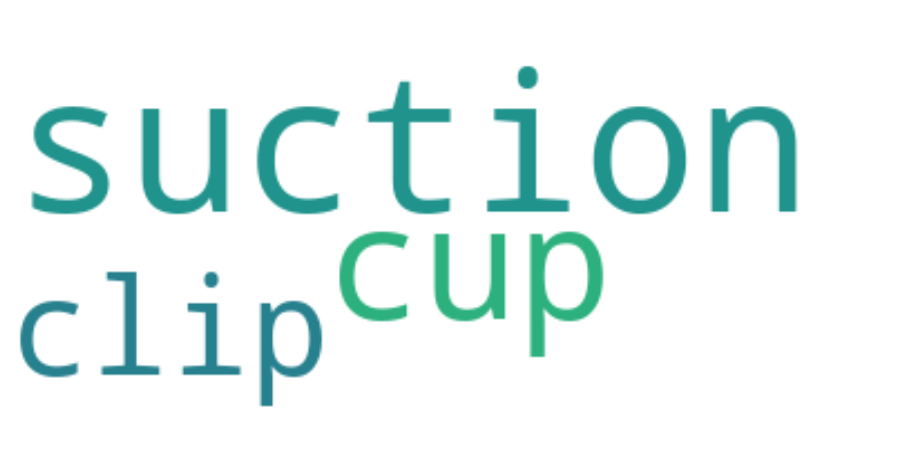

 The suction cup will not  hold  it in place 

The clip that  holds  the suction cup was broke on both and both strainers were cracked 

 Suctions are terrible & clips  don’t  hold basket 

 It wasn't able to  hold  the weight of food items put into it 

 It keeps coming off and doesn't  hold  up well at all 



In [10]:
keyword = 'hold'
x = keyword_wordcloud(df, original, keyword)

words which were frequently used with the keyword BASKET


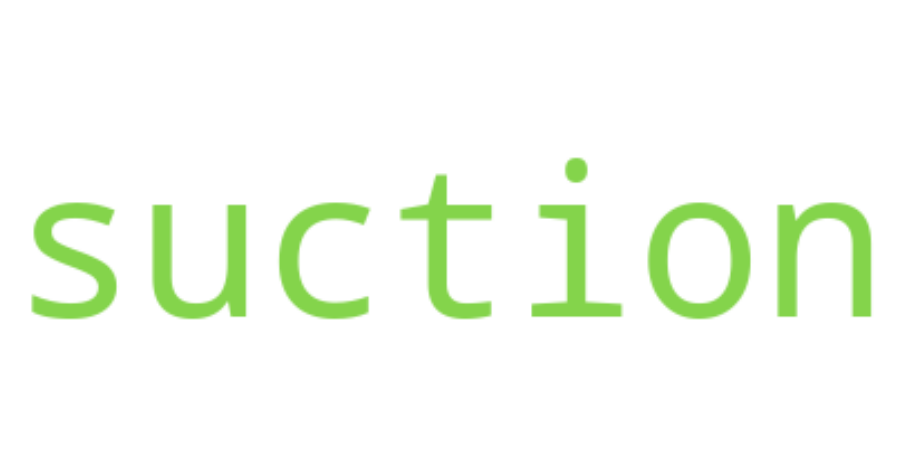

 Suctions are terrible & clips don’t  hold  basket 

I did not like that I only received one suction cup for two  baskets  



In [12]:
keyword = 'basket'
x = keyword_wordcloud(df, original, keyword)

words which were frequently used with the keyword LONG


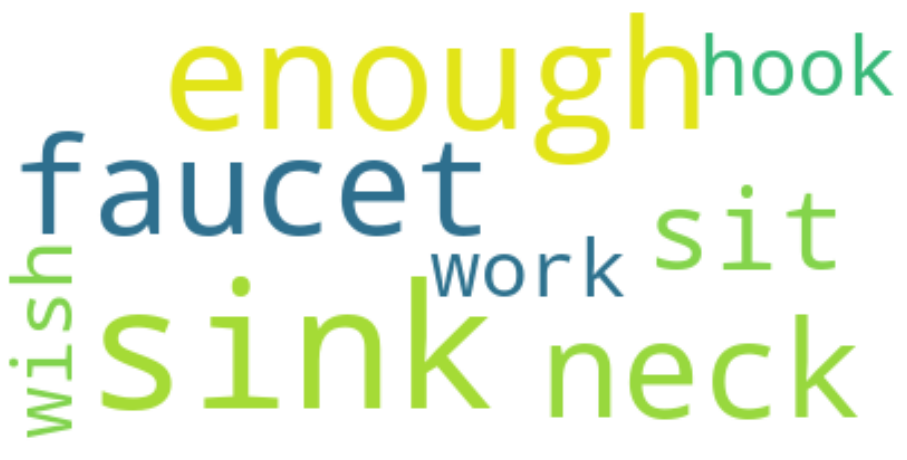

Can't use it on my sink and I waited too  long  to return 

Both my sinks it is not  long  enough hook to sit down in sink 

Deceiving pictures doesn’t show it on a real sink faucet! Too big and not  long  enough 

not  long  enough to work in sink 

 I don’t think it will last  long  

  Just wish the neck was  longer  so it worked better 

The neck is not  long  enough to attach to my faucet and hang over the sink 

 The neck is not  long  enough either even if the hook would accommodate the faucet 



In [308]:
keyword = 'long'
res = keyword_wordcloud(res.lemmatized, res.original, keyword)

words which were frequently used with the keyword WISH


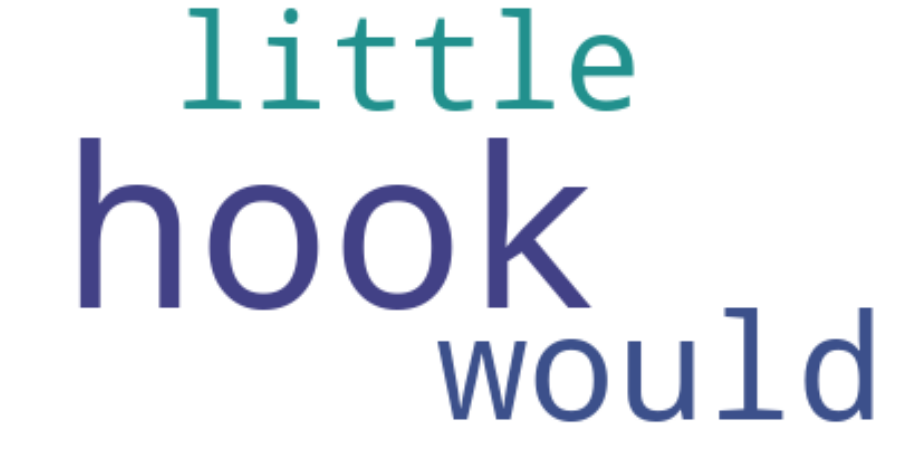

   Wish  it would be redesigned as it would be handy when cleaning vegetables 

 I just  wish  it was better quality plastic 

 I  wish  the neck was a little more flexible to go around my facet’s base 

  Wish  the hook was made for a range of a few sizes bigger/wider 

  Wish  they came up with an adjustable type hook or closure 

I  wish  the hook was a little bigger 

 I will still use, just  wish  it would work as stated 



In [313]:
keyword = 'wish'
res = keyword_wordcloud(res.lemmatized, res.original, keyword)

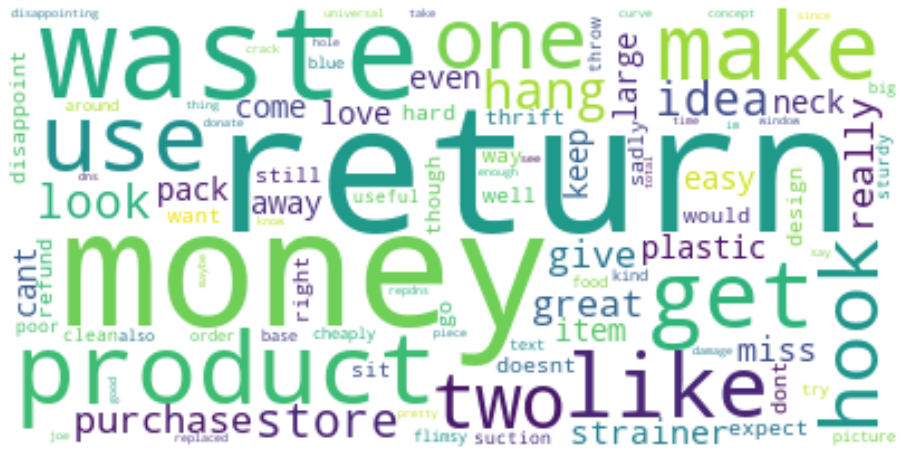

In [328]:
all_wordcloud(res.lemmatized)